#  Import Required Libraries

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt
import keras_tuner 
from kerastuner.tuners import RandomSearch

# Load and Preprocess the Dataset

In [23]:
def load_images_from_folder(folder, label, img_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)    
        img = cv2.resize(img, img_size)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

In [24]:
face_images, face_labels = load_images_from_folder("/kaggle/input/faces-dataset", 1)  # 1 for face
non_face_images, non_face_labels = load_images_from_folder("/kaggle/input/non-faces-dataset", 0)  # 0 for non-face

In [25]:
images = np.concatenate((face_images, non_face_images), axis=0)
labels = np.concatenate((face_labels, non_face_labels), axis=0)

In [26]:
# Normalize pixel values
images = images / 255.0

# Train and Test Dataset

In [28]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the CNN Architecture with Hyperparameters

In [29]:
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
                            (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp.Int('conv_2_filter', min_value=64, max_value=256, step=64),
                            (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

   
    model.add(layers.Conv2D(hp.Int('conv_3_filter', min_value=64, max_value=256, step=64),
                            (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                    hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

**Initialize the Keras Tuner for random search**

In [30]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  
    max_trials=10,
    executions_per_trial=2
)

Reloading Tuner from ./untitled_project/tuner0.json


**Search for the Best Hyperparameters**

In [31]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best hyperparameters are:
- Conv Layer 1 filters: {best_hps.get('conv_1_filter')}
- Conv Layer 2 filters: {best_hps.get('conv_2_filter')}
- Conv Layer 3 filters: {best_hps.get('conv_3_filter')}
- Dense units: {best_hps.get('dense_units')}
- Learning rate: {best_hps.get('learning_rate')}
""")


The best hyperparameters are:
- Conv Layer 1 filters: 32
- Conv Layer 2 filters: 64
- Conv Layer 3 filters: 192
- Dense units: 192
- Learning rate: 0.001



**Build the model with the best hyperparameters**

In [32]:
model = tuner.hypermodel.build(best_hps)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Train the model

In [33]:
Classifier_model = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.5882 - loss: 0.6808 - val_accuracy: 0.9062 - val_loss: 0.5742
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8343 - loss: 0.5056 - val_accuracy: 0.9375 - val_loss: 0.2634
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9446 - loss: 0.1915 - val_accuracy: 0.9688 - val_loss: 0.1475
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9738 - loss: 0.0907 - val_accuracy: 0.9531 - val_loss: 0.1271
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9503 - loss: 0.1332 - val_accuracy: 0.9531 - val_loss: 0.1341
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9716 - loss: 0.0695 - val_accuracy: 0.9531 - val_loss: 0.1299
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9812 - loss: 0.0495 - val_accuracy: 0.9375 - val_loss: 0.1623
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9714 - loss: 0.0545 - val_accuracy: 0.9688 - val_loss: 0.0716


# Evaluate Performance

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.9719 - loss: 0.0966
Test Accuracy: 0.9750000238418579


**Confusion Matrix**

In [35]:
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Confusion Matrix:
[[36  0]
 [ 2 42]]


**Plotting training & validation accuracy**

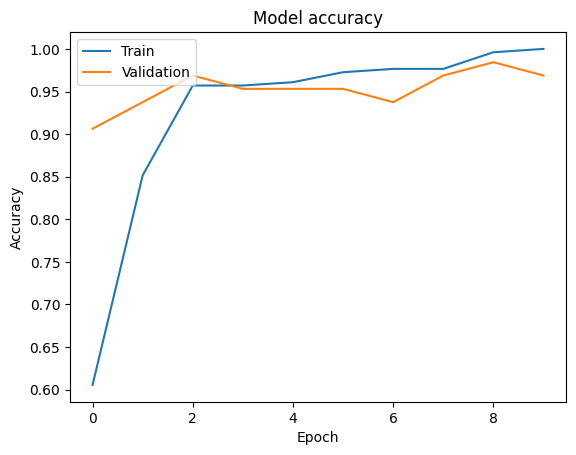

In [36]:
plt.plot(Classifier_model.history['accuracy'])
plt.plot(Classifier_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Plotting training & validation loss values**

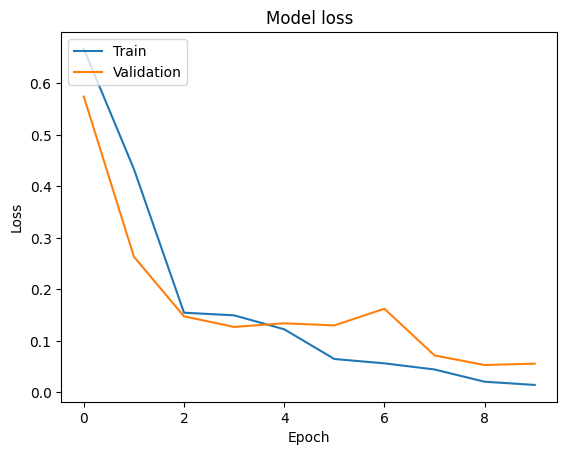

In [37]:
plt.plot(Classifier_model.history['loss'])
plt.plot(Classifier_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model

In [38]:
model.save('face_detection_cnn.h5')

# Use the Model

In [39]:
from tensorflow.keras.models import load_model
model = load_model('face_detection_cnn.h5')


In [40]:
image_path = "/kaggle/input/try-test/motorbike_0205.jpg"
image = cv2.imread(image_path)
if image is None:
    print("Error: Image not found.")
else:
    img_size = (64, 64)
    resized_image = cv2.resize(image, img_size)
    resized_image = resized_image / 255.0 
    resized_image = np.expand_dims(resized_image, axis=0)  

    prediction = model.predict(resized_image)
    if prediction > 0.5:
        print("There is a face in the image!")
    else:
        print("No face is detected in the image.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
No face is detected in the image.
